### Imports and CUDA

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch import utils

from torchvision import transforms 
from torchvision import datasets

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
import datetime

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Load CIFAR-10 dataset from PyTorch's library

In [3]:
# Define image transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 training data
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Extract validation data
val_size = 5000
train_size = len(trainset) - val_size
trainset, valset = utils.data.random_split(trainset, [train_size, val_size])

# Load CIFAR-10 testing data
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define dataloaders with batch size = 64
trainloader = utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = utils.data.DataLoader(valset, batch_size=64)
testloader = utils.data.DataLoader(testset, batch_size=64, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Define the CNN's architecture


In [5]:
class CNN(nn.Module):
   
    def __init__(self, activation):

        super(CNN, self).__init__()
        self.activation = activation
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.activation(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            self.activation(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            self.activation(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            self.activation(),
            nn.Linear(1024, 512),
            self.activation(),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

    def forward(self, x):

        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

### Function to train the model

In [6]:
def train(model, criterion, optimizer, epochs=10, verbose=True):

    stats = []    # Stores val_acc, train_acc, val_loss, train_loss for each epoch

    st = datetime.datetime.now()

    for epoch in range(epochs):

        # Training Phase
        correct = 0 
        total = 0 
        for i, data in enumerate(trainloader):
            inputs = data[0].to(device)
            labels = data[1].to(device)
            # Reset gradient 
            optimizer.zero_grad()
            # Do forward prop
            logits = model(inputs)
            # Compute loss
            loss = criterion(logits, labels)
            # Backpropagate
            loss.backward()
            optimizer.step()
            # Training accuracy
            _, pred_labels = torch.max(logits.data, dim=1)
            correct += (pred_labels == labels).sum()
            total += labels.size(0)

        train_loss = loss.item()
        train_acc = 100*(correct/total).item()

        # Validation Phase
        correct = 0 
        total = 0 
        # Since we're not training, we don't need to compute the gradients 
        with torch.no_grad():
            for i, data in enumerate(valloader):
                inputs = data[0].to(device)
                labels = data[1].to(device)
                # Do forward prop
                logits = model(inputs)
                loss = criterion(logits, labels)
                _, pred_labels = torch.max(logits.data, dim=1)
                correct += (pred_labels == labels).sum()
                total += labels.size(0)

        val_loss = loss.item()
        val_acc = 100*(correct/total).item()

        # Print after every 3rd epoch
        if(epoch % 3 == 0 and verbose == True): 
            print(f'Epoch {epoch+1}: \t Trn Loss {train_loss:.2f} \t Val Loss {val_loss:.2f} \t Trn Acc {train_acc:.2f} % \t Val Acc {val_acc:.2f} %')

        # Store epoch's stats in stats array
        stats.append({'val_acc': val_acc, 'train_acc': train_acc, 'val_loss': val_loss, 'train_loss': train_loss})

    et = datetime.datetime.now()
    training_time = et - st
    
    # Print after all epochs
    if(verbose == True): print(f'\nTraining Time: \t {training_time} seconds')

    # Return training time & training stats
    return training_time, stats

### Function to plot model training stats

In [7]:
# stats -> [ 'epoch 1 results', 'epoch 2 results', ..., 'last epoch results' ]
  
# epoch n results -> { val_acc: ?, train_acc: ?, val_loss: ?, train_loss: ? }

def plot_train_stats(stats, suptitle):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    if(suptitle != ''): fig.suptitle(suptitle, fontweight='bold')

    # Plot accuracy stats
    val_acc_arr = [x['val_acc'] for x in stats]
    train_acc_arr = [x['train_acc'] for x in stats]
    ax1.plot(val_acc_arr, '-rx')
    ax1.plot(train_acc_arr, '-bx')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['Validation', 'Training'])
    ax1.set_title('Accuracy vs. No. of epochs')

    # Plot loss stats
    val_loss_arr = [x['val_loss'] for x in stats]
    train_loss_arr = [x['train_loss'] for x in stats]
    ax2.plot(val_loss_arr, '-rx')
    ax2.plot(train_loss_arr, '-bx')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend(['Validation', 'Training'])
    ax2.set_title('Loss vs. No. of epochs')

### Function to plot training time vs momentum for different momentum values

In [8]:
def plot_train_time_vs_mom(time_arr, mom_arr):
    plt.figure(figsize=(7,5))
    plt.plot(mom_arr, time_arr, '-rx')
    plt.xlabel('momentum value')
    plt.ylabel('training time (seconds)')
    plt.title('Training time vs. Momentum values')

### Function to plot validation accuracy vs momentum for different momentum values

In [9]:
def plot_val_acc_vs_mom(val_acc_arr, mom_arr):
    plt.figure(figsize=(7,5))
    plt.plot(mom_arr, val_acc_arr, '-rx')
    plt.xlabel('momentum value')
    plt.ylabel('validation accuracy (%)')
    plt.title('Validation accuracy vs. Momentum values')

### 1) ReLU without momentum

In [10]:
# relu without momentum
r_wo_m = CNN(nn.ReLU).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(r_wo_m.parameters(), lr=0.1)

r_wo_m_trn_time, r_wo_m_stats = train(r_wo_m, criterion, optimizer)
r_wo_m_val_acc = r_wo_m_stats[-1]['val_acc']

Epoch 1: 	 Trn Loss 0.82 	 Val Loss 1.14 	 Trn Acc 48.46 % 	 Val Acc 52.38 %
Epoch 4: 	 Trn Loss 0.39 	 Val Loss 0.29 	 Trn Acc 76.20 % 	 Val Acc 65.10 %
Epoch 7: 	 Trn Loss 0.08 	 Val Loss 0.29 	 Trn Acc 84.91 % 	 Val Acc 77.50 %
Epoch 10: 	 Trn Loss 0.74 	 Val Loss 0.52 	 Trn Acc 91.48 % 	 Val Acc 64.48 %

Training Time: 	 0:02:21.143928 seconds


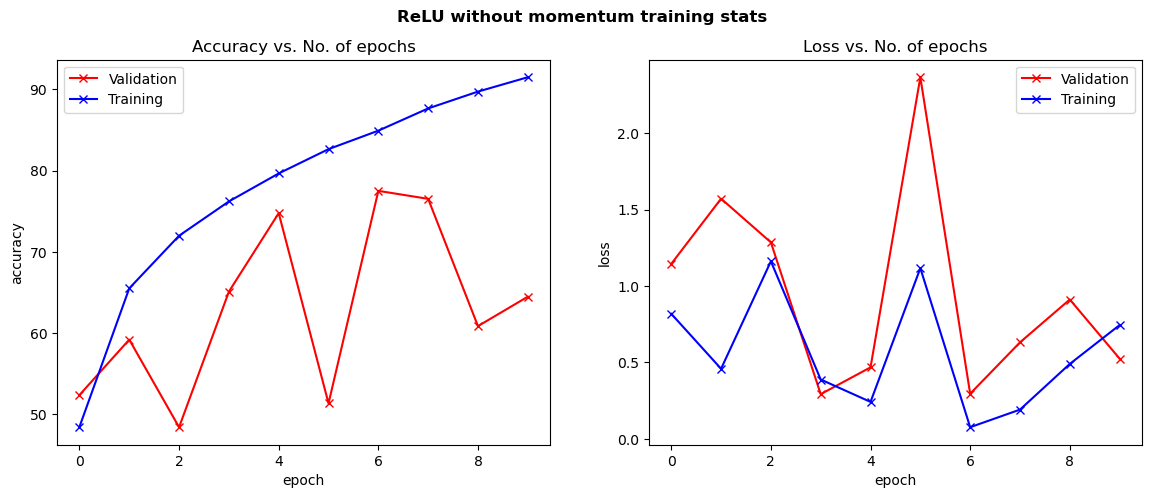

In [11]:
plot_train_stats(r_wo_m_stats, 'ReLU without momentum training stats')

### 2) ReLU with momentum

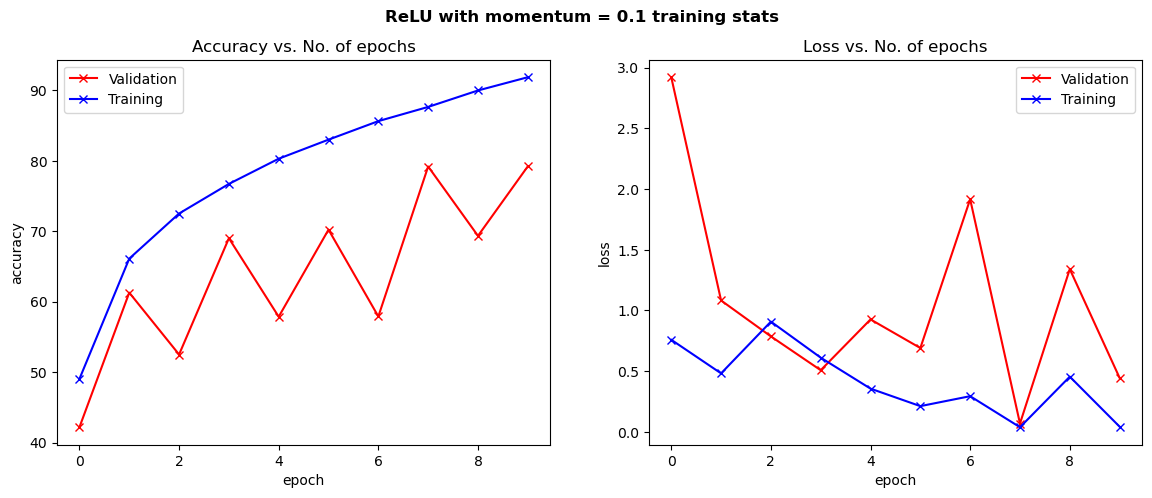

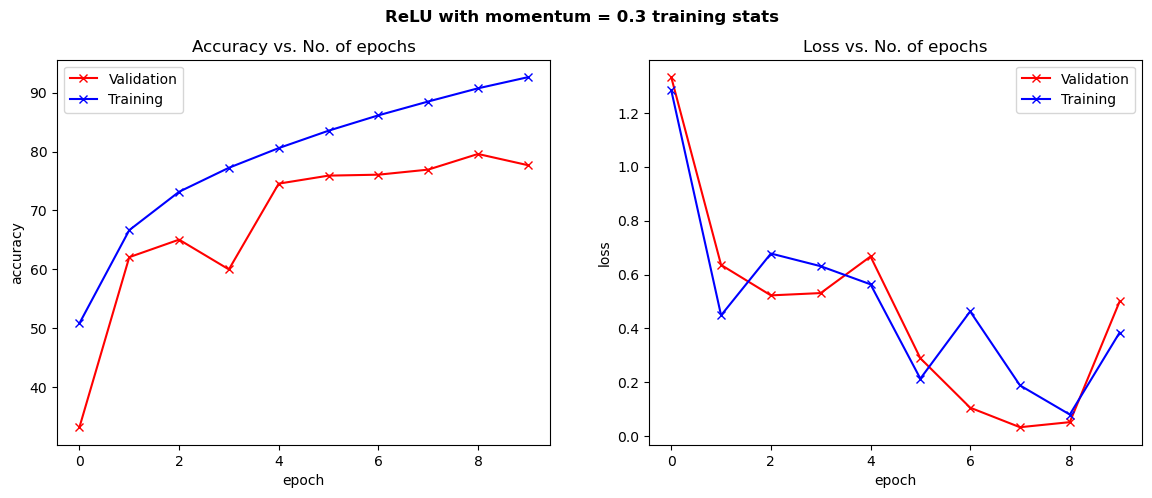

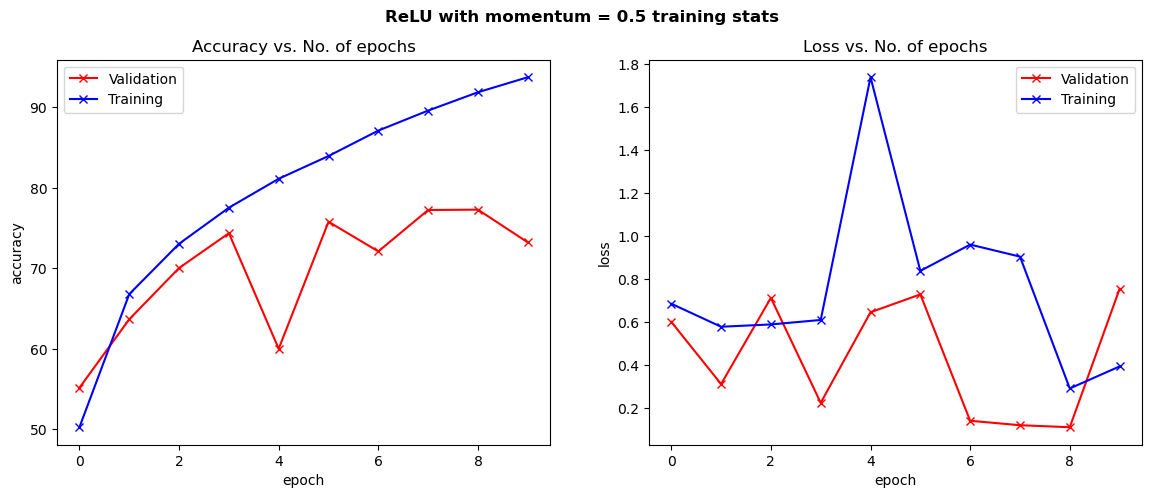

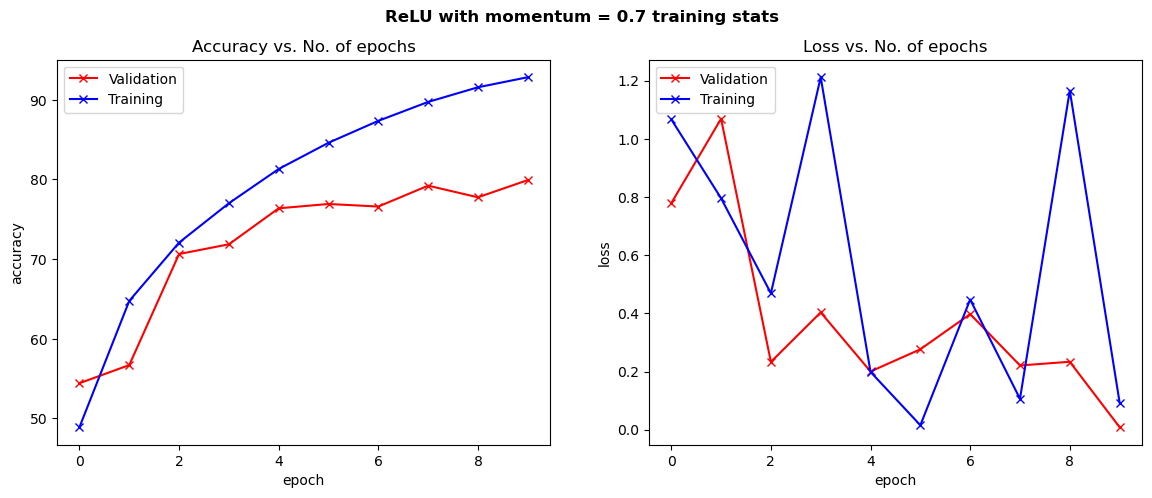

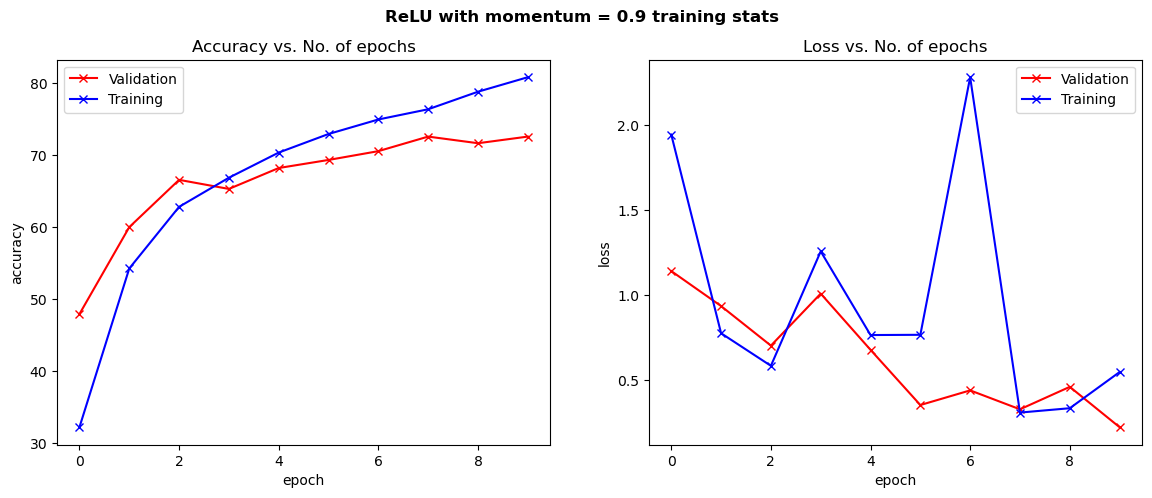

In [12]:
# Try different momentum values
mom_arr = [0.1, 0.3, 0.5, 0.7, 0.9] 

# There will be 5 models for 5 different momentum values
r_w_m_arr = [] # Stores models
r_w_m_trn_time_arr = [] # Stores training time
r_w_m_val_acc_arr = [] # Stores validation accuracy

for mom in mom_arr:
    # Define loss criteria and optimizer
    r_w_m = CNN(nn.ReLU).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(r_w_m.parameters(), lr=0.1, momentum=mom)

    # Train model
    r_w_m_trn_time, r_w_m_stats = train(r_w_m, criterion, optimizer, verbose=False)

    # Plot training stats
    plot_train_stats(r_w_m_stats, suptitle=f'ReLU with momentum = {mom} training stats')
    plt.show()

    # Save model, its training time & its validation accuracy
    r_w_m_arr.append(r_w_m)
    r_w_m_trn_time_arr.append(r_w_m_trn_time)
    r_w_m_val_acc_arr.append(r_w_m_stats[-1]['val_acc'])

To choose the best momentum value:

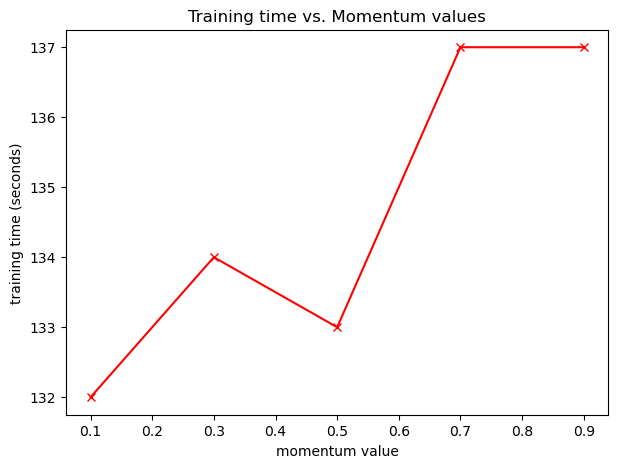

In [13]:
plot_train_time_vs_mom([x.seconds for x in r_w_m_trn_time_arr], mom_arr)

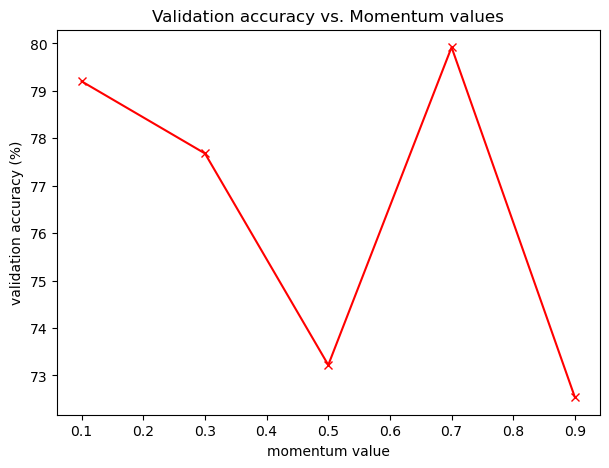

In [14]:
plot_val_acc_vs_mom(r_w_m_val_acc_arr, mom_arr)

Momentum = 0.7 seems best (both training time wise and validation accuracy wise)

### 3) ReLU with Adam

In [16]:
# relu with adam
r_w_a = CNN(nn.ReLU).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(r_w_a.parameters(), lr=0.1)

r_w_a_trn_time, r_w_a_stats = train(r_w_a, criterion, optimizer)
r_w_a_val_acc = r_w_a_stats[-1]['val_acc']

Epoch 1: 	 Trn Loss 2.29 	 Val Loss 2.23 	 Trn Acc 11.48 % 	 Val Acc 11.54 %
Epoch 4: 	 Trn Loss 1.93 	 Val Loss 2.04 	 Trn Acc 18.88 % 	 Val Acc 19.66 %
Epoch 7: 	 Trn Loss 2.29 	 Val Loss 2.30 	 Trn Acc 10.20 % 	 Val Acc 10.10 %
Epoch 10: 	 Trn Loss 2.27 	 Val Loss 2.29 	 Trn Acc 10.34 % 	 Val Acc 10.74 %

Training Time: 	 0:02:26.021074 seconds


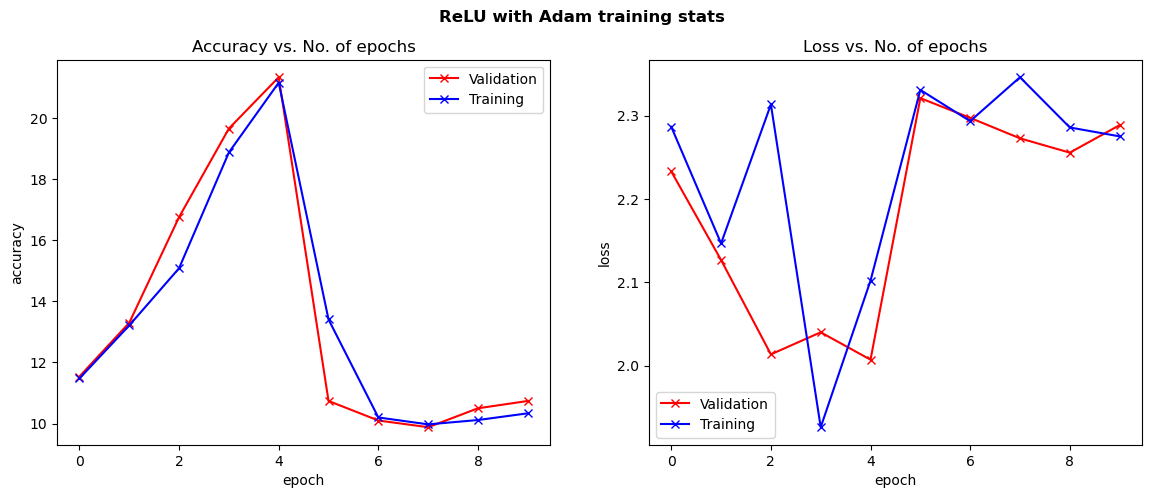

In [17]:
plot_train_stats(r_w_a_stats, suptitle='ReLU with Adam training stats')

Why is Adam performing so poorly?

### 4) Sigmoid without momentum

In [18]:
# sigmoid without momentum
s_wo_m = CNN(nn.Sigmoid).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(s_wo_m.parameters(), lr=0.1)

s_wo_m_trn_time, s_wo_m_stats = train(s_wo_m, criterion, optimizer)
s_wo_m_val_acc = s_wo_m_stats[-1]['val_acc']

Epoch 1: 	 Trn Loss 2.39 	 Val Loss 1.86 	 Trn Acc 14.57 % 	 Val Acc 10.42 %
Epoch 4: 	 Trn Loss 1.62 	 Val Loss 1.69 	 Trn Acc 36.58 % 	 Val Acc 29.34 %
Epoch 7: 	 Trn Loss 1.16 	 Val Loss 1.36 	 Trn Acc 47.64 % 	 Val Acc 45.20 %
Epoch 10: 	 Trn Loss 0.92 	 Val Loss 1.23 	 Trn Acc 55.54 % 	 Val Acc 42.32 %

Training Time: 	 0:02:17.945002 seconds


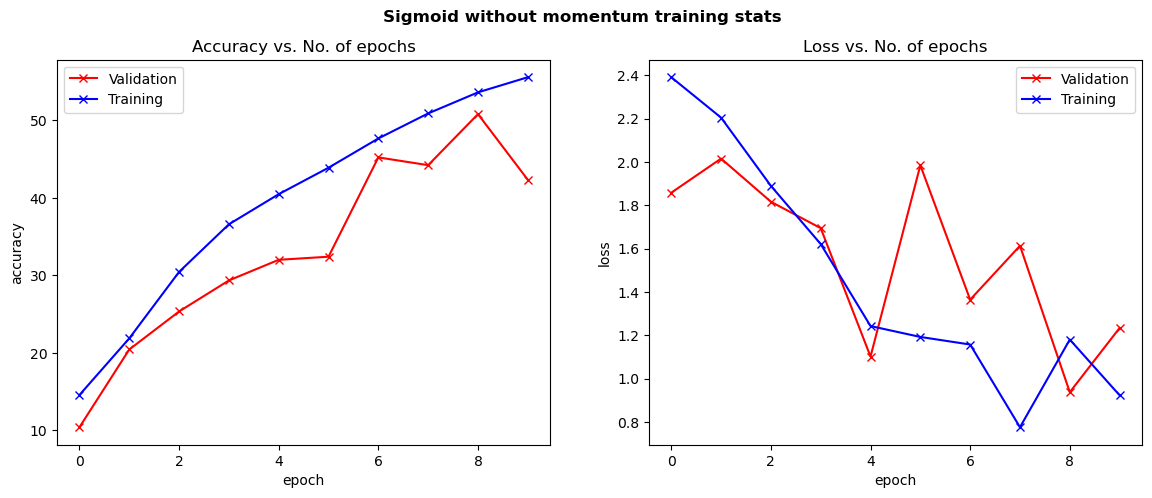

In [19]:
plot_train_stats(s_wo_m_stats, 'Sigmoid without momentum training stats')

### 5) Sigmoid with momentum

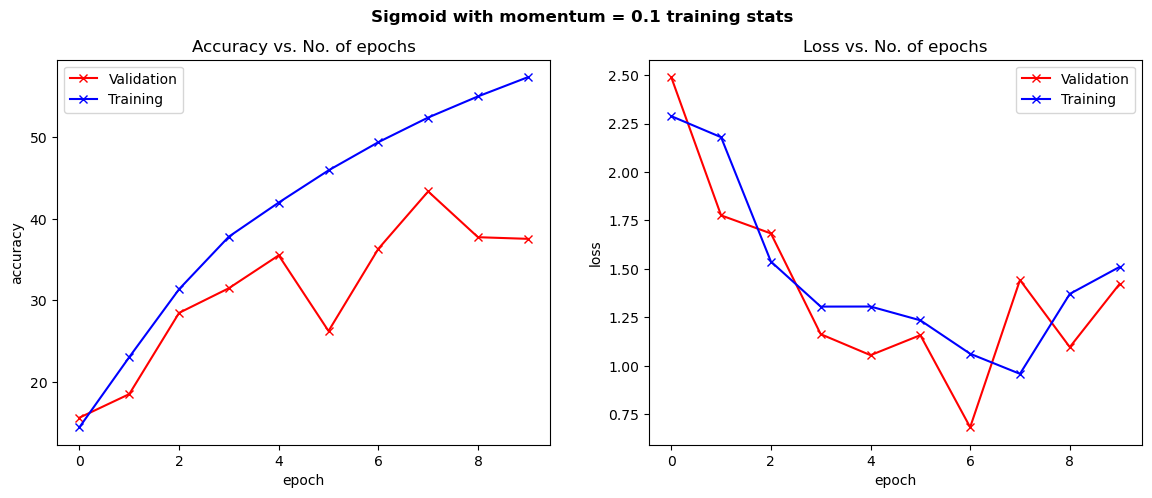

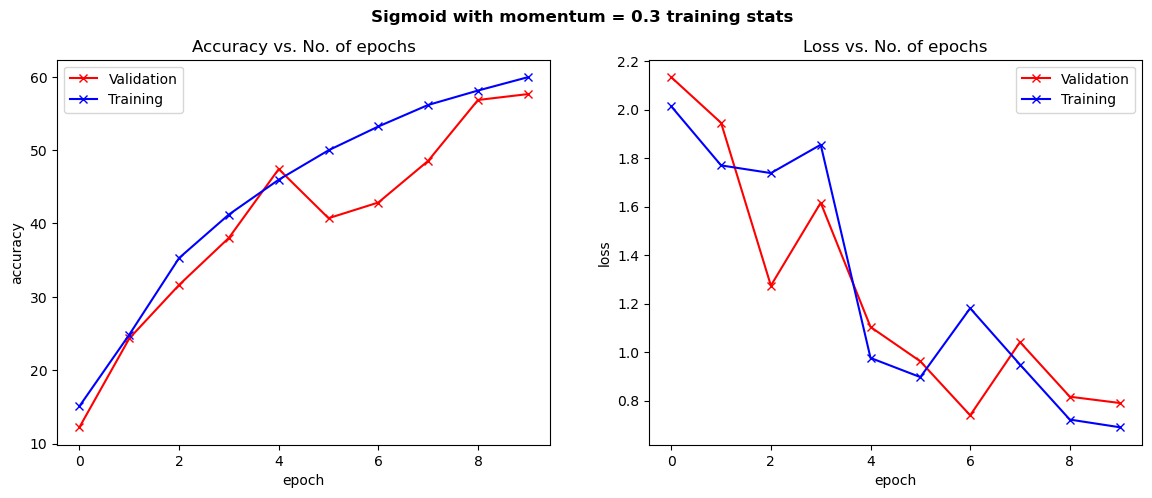

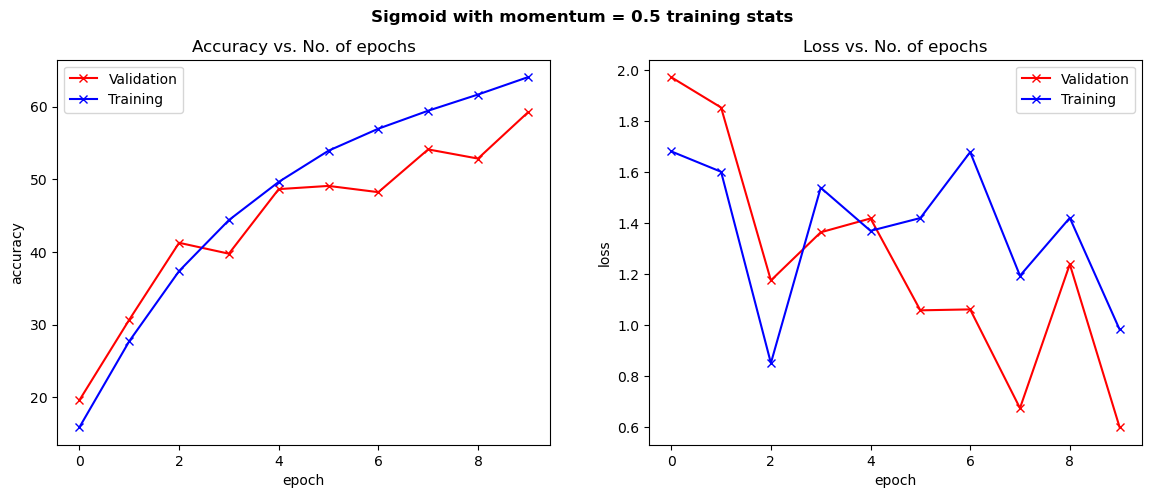

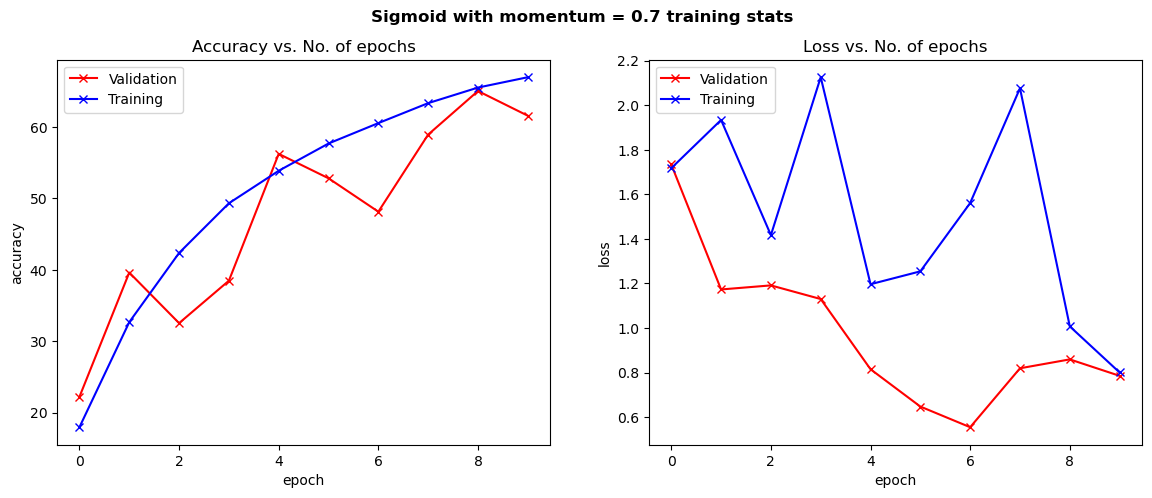

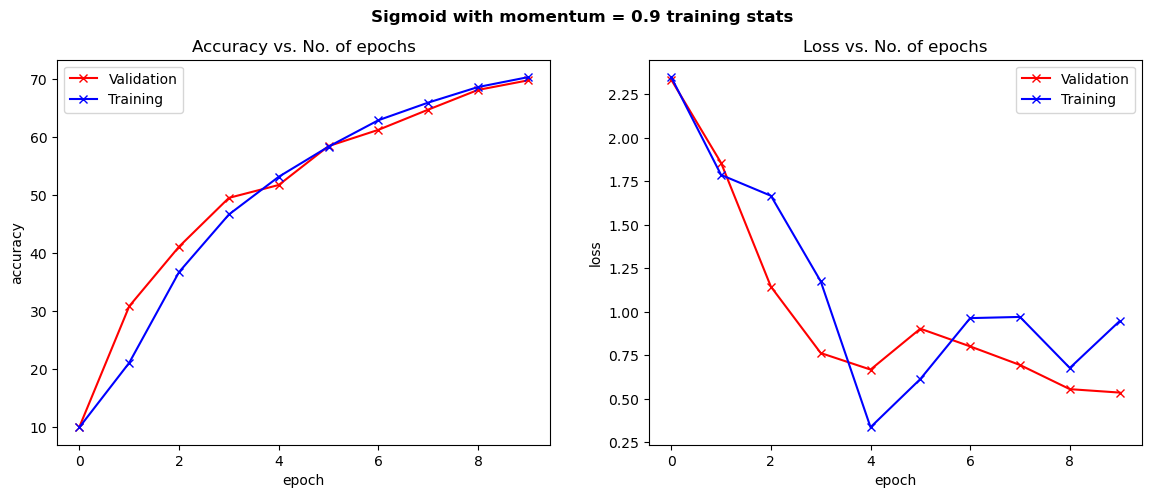

In [20]:
# Try different momentum values
mom_arr = [0.1, 0.3, 0.5, 0.7, 0.9] 

# There will be 5 models for 5 different momentum values
s_w_m_arr = [] # Stores models
s_w_m_trn_time_arr = [] # Stores training time
s_w_m_val_acc_arr = [] # Stores validation accuracy

for mom in mom_arr:
    # Define loss criteria and optimizer
    s_w_m = CNN(nn.Sigmoid).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(s_w_m.parameters(), lr=0.1, momentum=mom)

    # Train model
    s_w_m_trn_time, s_w_m_stats = train(s_w_m, criterion, optimizer, verbose=False)

    # Plot training stats
    plot_train_stats(s_w_m_stats, suptitle=f'Sigmoid with momentum = {mom} training stats')
    plt.show()

    # Save model & its training time
    s_w_m_arr.append(s_w_m)
    s_w_m_trn_time_arr.append(s_w_m_trn_time)
    s_w_m_val_acc_arr.append(s_w_m_stats[-1]['val_acc'])

To choose the best momentum value:

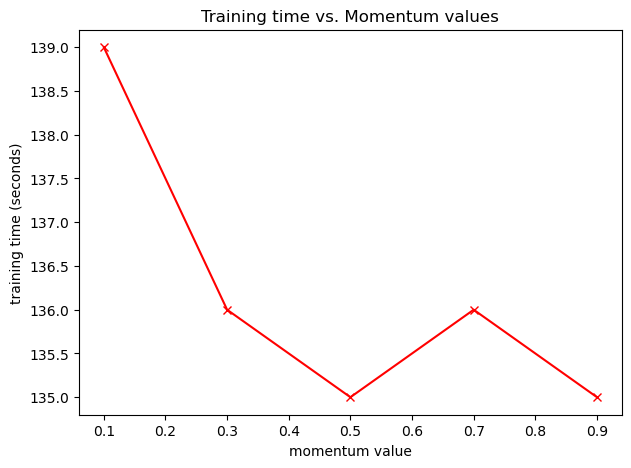

In [21]:
plot_train_time_vs_mom([x.seconds for x in s_w_m_trn_time_arr], mom_arr)

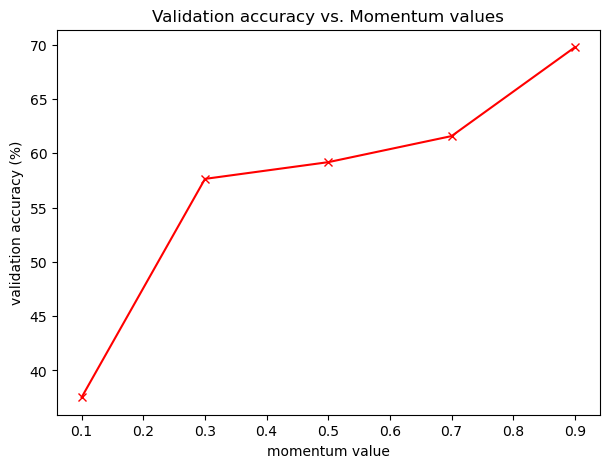

In [22]:
plot_val_acc_vs_mom(s_w_m_val_acc_arr, mom_arr)

Momentum = 0.9 seems best (both training time wise and validation accuracy wise)

### 6) Sigmoid with Adam

In [24]:
# sigmoid with adam
s_w_a = CNN(nn.Sigmoid).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(s_w_a.parameters(), lr=0.1)

s_w_a_trn_time, s_w_a_stats = train(s_w_a, criterion, optimizer)
s_w_a_val_acc = s_w_a_stats[-1]['val_acc']

Epoch 1: 	 Trn Loss 2.58 	 Val Loss 4.29 	 Trn Acc 9.87 % 	 Val Acc 9.98 %
Epoch 4: 	 Trn Loss 5.92 	 Val Loss 6.95 	 Trn Acc 9.92 % 	 Val Acc 9.92 %
Epoch 7: 	 Trn Loss 8.92 	 Val Loss 6.86 	 Trn Acc 9.76 % 	 Val Acc 8.94 %
Epoch 10: 	 Trn Loss 4.24 	 Val Loss 7.56 	 Trn Acc 9.97 % 	 Val Acc 9.88 %

Training Time: 	 0:02:21.437474 seconds


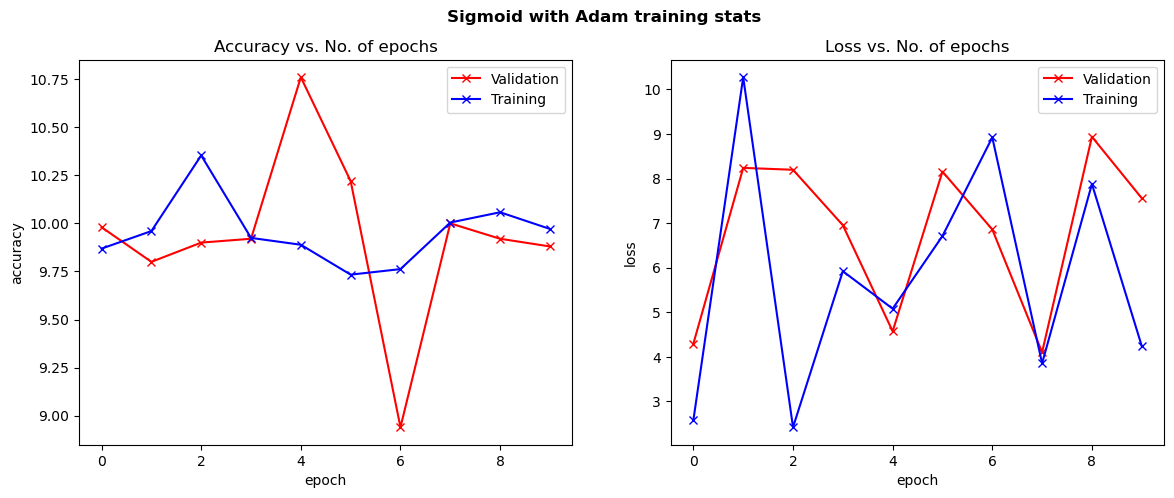

In [25]:
plot_train_stats(s_w_a_stats, suptitle='Sigmoid with Adam training stats')

### 7) Tanh without momentum

In [26]:
# tanh without momentum
t_wo_m = CNN(nn.Tanh).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(t_wo_m.parameters(), lr=0.1)

t_wo_m_trn_time, t_wo_m_stats = train(t_wo_m, criterion, optimizer)
t_wo_m_val_acc = t_wo_m_stats[-1]['val_acc']

Epoch 1: 	 Trn Loss 1.77 	 Val Loss 2.25 	 Trn Acc 46.77 % 	 Val Acc 29.94 %
Epoch 4: 	 Trn Loss 0.83 	 Val Loss 0.81 	 Trn Acc 69.38 % 	 Val Acc 51.78 %
Epoch 7: 	 Trn Loss 1.79 	 Val Loss 0.77 	 Trn Acc 78.28 % 	 Val Acc 39.30 %
Epoch 10: 	 Trn Loss 0.03 	 Val Loss 0.03 	 Trn Acc 85.49 % 	 Val Acc 73.52 %

Training Time: 	 0:02:10.552976 seconds


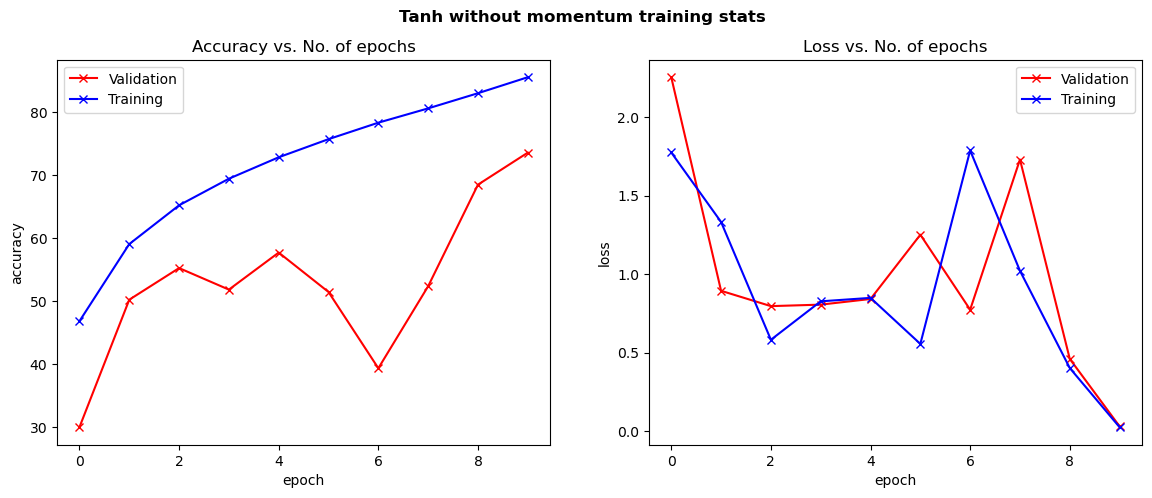

In [27]:
plot_train_stats(t_wo_m_stats, 'Tanh without momentum training stats')

### 8) Tanh with momentum

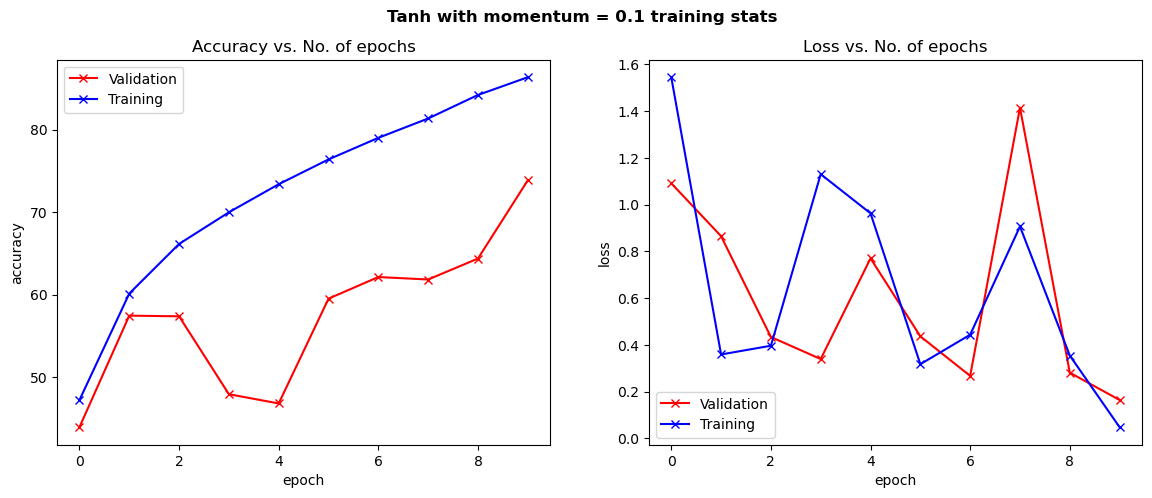

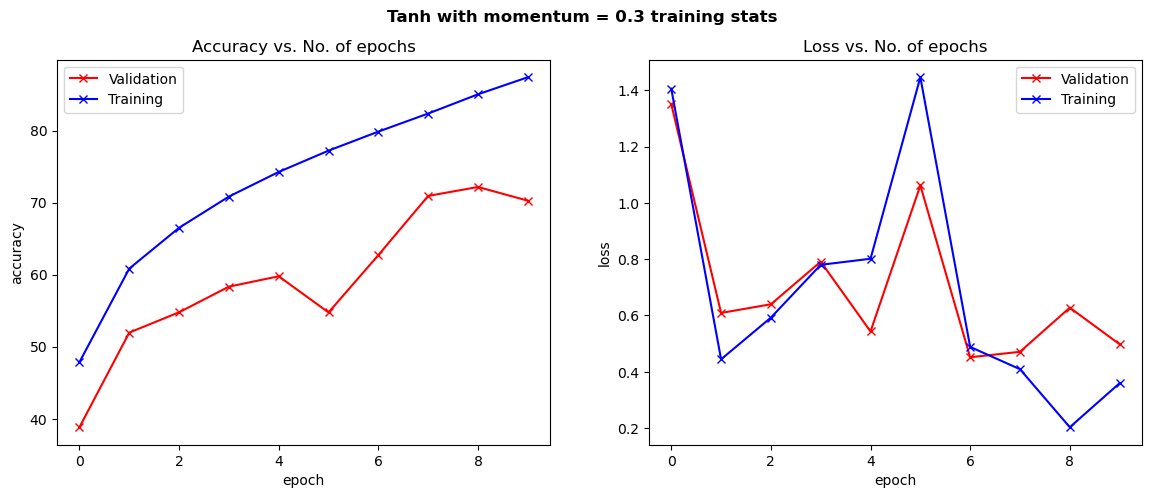

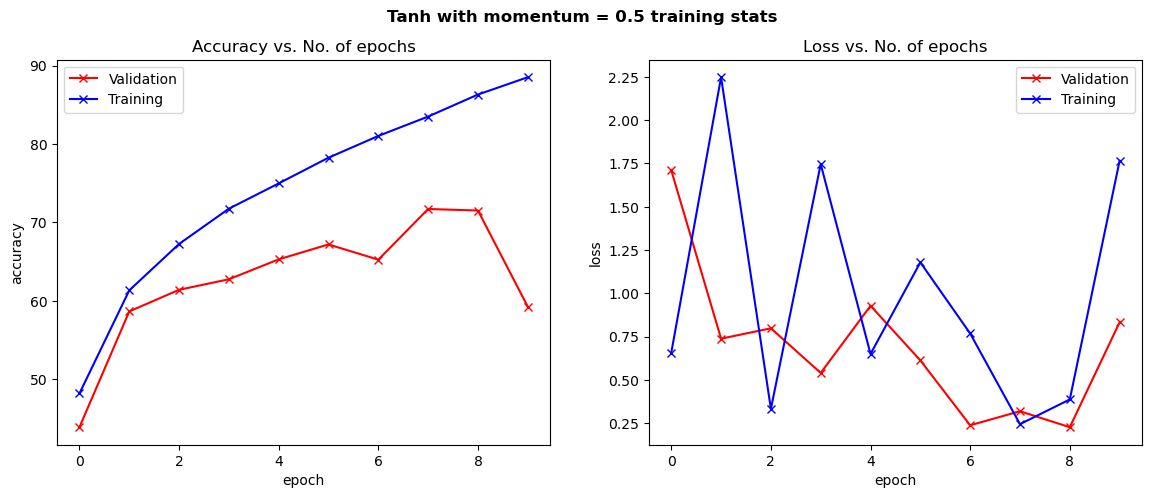

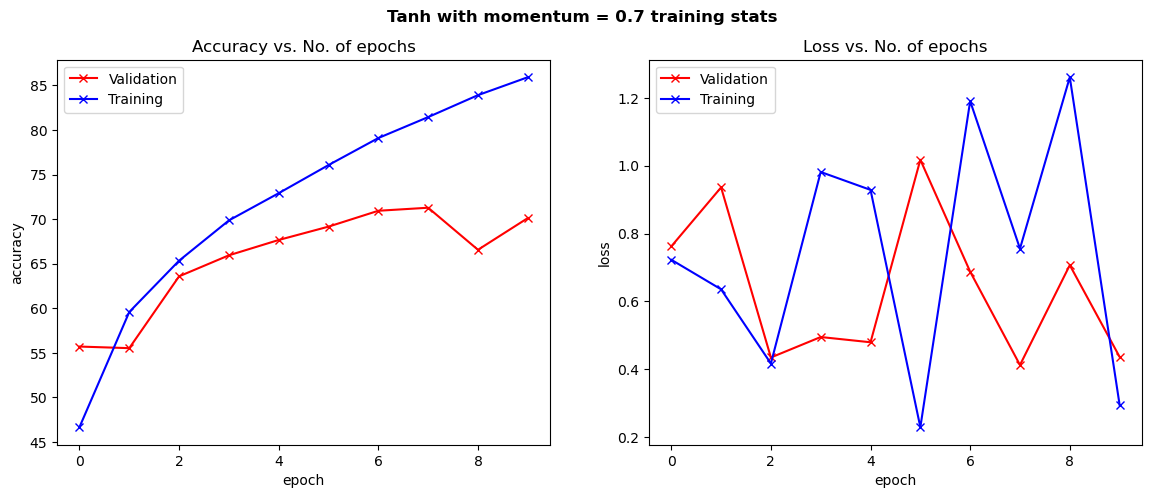

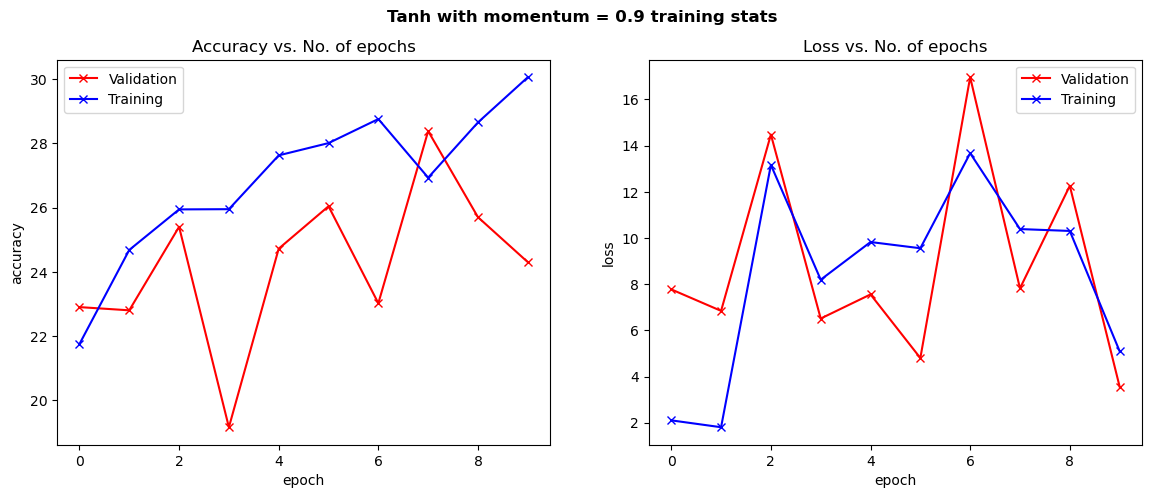

In [28]:
# Try different momentum values
mom_arr = [0.1, 0.3, 0.5, 0.7, 0.9] 

# There will be 5 models for 5 different momentum values
t_w_m_arr = [] # Stores models
t_w_m_trn_time_arr = [] # Stores training time
t_w_m_val_acc_arr = [] # Stores validation accuracy

for mom in mom_arr:
    # Define loss criteria and optimizer
    t_w_m = CNN(nn.Tanh).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(t_w_m.parameters(), lr=0.1, momentum=mom)

    # Train model
    t_w_m_trn_time, t_w_m_stats = train(t_w_m, criterion, optimizer, verbose=False)

    # Plot training stats
    plot_train_stats(t_w_m_stats, suptitle=f'Tanh with momentum = {mom} training stats')
    plt.show()

    # Save model & its training time
    t_w_m_arr.append(t_w_m)
    t_w_m_trn_time_arr.append(t_w_m_trn_time)
    t_w_m_val_acc_arr.append(t_w_m_stats[-1]['val_acc'])

To choose the best momentum value:

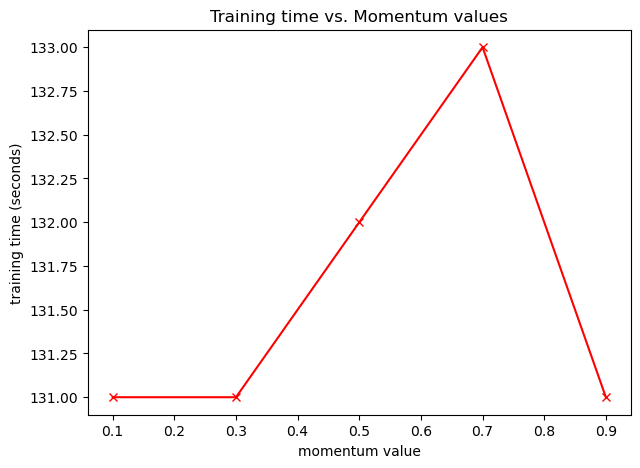

In [29]:
plot_train_time_vs_mom([x.seconds for x in t_w_m_trn_time_arr], mom_arr)

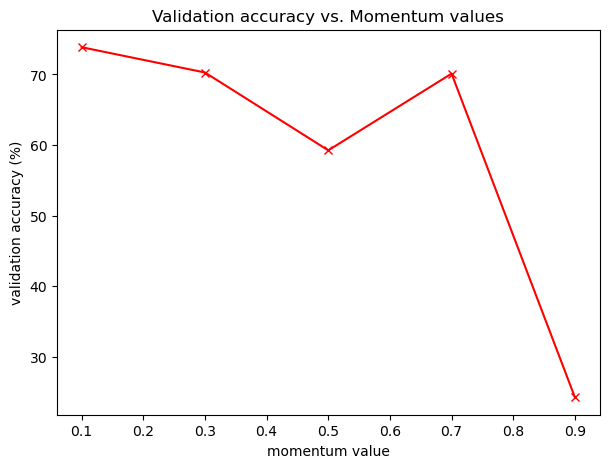

In [30]:
plot_val_acc_vs_mom(t_w_m_val_acc_arr, mom_arr)

Momentum = 0.1 seems best (both training time wise and validation accuracy wise)

### 9) Tanh with Adam

In [32]:
# tanh with adam
t_w_a = CNN(nn.Tanh).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(t_w_a.parameters(), lr=0.1)

t_w_a_trn_time, t_w_a_stats = train(t_w_a, criterion, optimizer)
t_w_a_val_acc = t_w_a_stats[-1]['val_acc']

Epoch 1: 	 Trn Loss 52.89 	 Val Loss 24.09 	 Trn Acc 11.49 % 	 Val Acc 9.84 %
Epoch 4: 	 Trn Loss 10.71 	 Val Loss 9.83 	 Trn Acc 9.89 % 	 Val Acc 10.32 %
Epoch 7: 	 Trn Loss 18.92 	 Val Loss 21.24 	 Trn Acc 10.01 % 	 Val Acc 9.76 %
Epoch 10: 	 Trn Loss 18.29 	 Val Loss 12.76 	 Trn Acc 10.20 % 	 Val Acc 9.98 %

Training Time: 	 0:02:21.535335 seconds


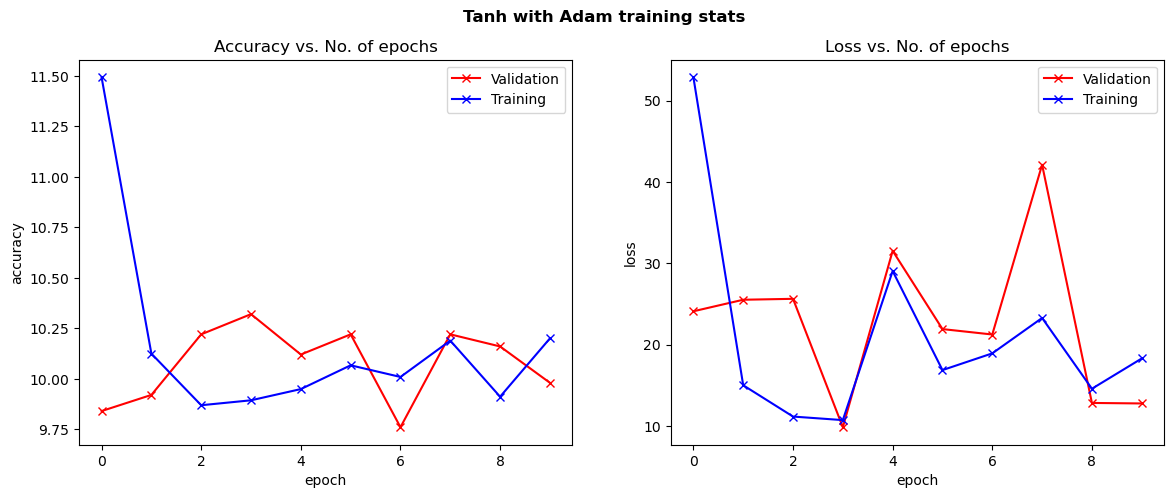

In [33]:
plot_train_stats(t_w_a_stats, suptitle='Tanh with Adam training stats')

### Choosing the best model

In [41]:
print('ReLU without momentum:')
print('Training time:', r_wo_m_trn_time)
print('Validation accuracy:', r_wo_m_val_acc)
print()

print(f'ReLU with momentum {mom_arr[3]}:')
print('Training time:', r_w_m_trn_time_arr[3])
print('Validation accuracy:', r_w_m_val_acc_arr[3])
print()

print('ReLU with Adam:')
print('Training time:', r_w_a_trn_time)
print('Validation accuracy:', r_w_a_val_acc)
print()

print('Sigmoid without momentum:')
print('Training time:', s_wo_m_trn_time)
print('Validation accuracy:', s_wo_m_val_acc)
print()

print(f'Sigmoid with momentum {mom_arr[4]}:')
print('Training time:', s_w_m_trn_time_arr[4])
print('Validation accuracy:', s_w_m_val_acc_arr[4])
print()

print('Sigmoid with Adam:')
print('Training time:', s_w_a_trn_time)
print('Validation accuracy:', s_w_a_val_acc)
print()

print('Tanh without momentum:')
print('Training time:', t_wo_m_trn_time)
print('Validation accuracy:', t_wo_m_val_acc)
print()

print(f'Tanh with momentum {mom_arr[0]}:')
print('Training time:', t_w_m_trn_time_arr[0])
print('Validation accuracy:', t_w_m_val_acc_arr[0])
print()

print('Tanh with Adam:')
print('Training time:', t_w_a_trn_time)
print('Validation accuracy:', t_w_a_val_acc)
print()

ReLU without momentum:
Training time: 0:02:21.143928
Validation accuracy: 64.48000073432922

ReLU with momentum 0.7:
Training time: 0:02:17.519034
Validation accuracy: 79.91999983787537

ReLU with Adam:
Training time: 0:02:26.021074
Validation accuracy: 10.740000009536743

Sigmoid without momentum:
Training time: 0:02:17.945002
Validation accuracy: 42.319998145103455

Sigmoid with momentum 0.9:
Training time: 0:02:15.512908
Validation accuracy: 69.760000705719

Sigmoid with Adam:
Training time: 0:02:21.437474
Validation accuracy: 9.879999607801437

Tanh without momentum:
Training time: 0:02:10.552976
Validation accuracy: 73.51999878883362

Tanh with momentum 0.1:
Training time: 0:02:11.225336
Validation accuracy: 73.8599956035614

Tanh with Adam:
Training time: 0:02:21.535335
Validation accuracy: 9.97999981045723



- Training times are almost similar at 2 mins 20 seconds

- Best validation accuracy is for ReLU with momentum 0.7 which is equal to 79.91 %

### Function to test the network

In [35]:
def test(model):
    correct = 0
    total = 0
    # Since we're not training, we don't need to calculate the gradients 
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            logits = model(images)
            # The class with the highest energy is what we choose as prediction
            _, pred_labels = torch.max(logits.data, dim=1)
            correct += (pred_labels == labels).sum().item()
            total += labels.size(0)
    test_acc = 100*(correct/total)
    # Print test accuracy
    print(f'Accuracy of the network on test set (10,000 images): {test_acc:.2f} %')

### Testing the best model

In [43]:
test(r_w_m_arr[3])

Accuracy of the network on test set (10,000 images): 78.72 %


Our best model was ReLU with momentum = 0.7 and its testing accuracy is 78.72 %